In [299]:
%reload_ext autoreload
%autoreload 2
import pipeline
import explore as e
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import loops as l
from sklearn.model_selection import ParameterGrid

#### Load and Process Data

In [221]:
pipe = pipeline.process(pipeline.path)
df = pipe.data

In [222]:
## Change types 
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['year_posted'], df['month_posted'] = df['date_posted'].dt.year, df['date_posted'].dt.month

In [223]:
### Make Target Column
df['diff'] = (df['datefullyfunded'] - df['date_posted']).dt.days
df['outcome'] = np.where(df['diff']<= 60, 1, 0)

In [224]:
### Convert T/F to binary 0/1
true_false = ['school_magnet', 'school_charter', 'eligible_double_your_impact_match']
for col in true_false:
    df[col] = np.where(df[col] == 't', 1, 0)

#### Handle Nulls

In [225]:
### Confirming that each row is a unique project id -- number of rows in df is equal to number if unique project ids 
df['projectid'].nunique() == df.shape[0]

True

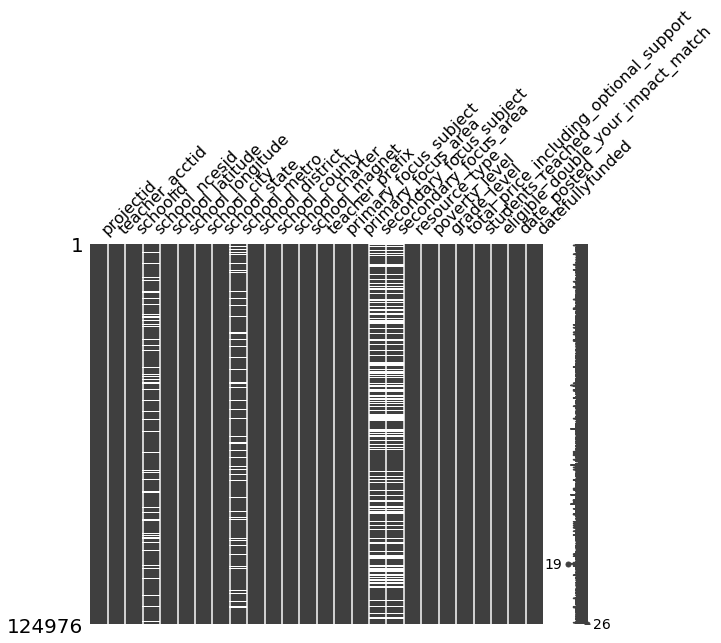

In [11]:
e.missing_matrix(df)

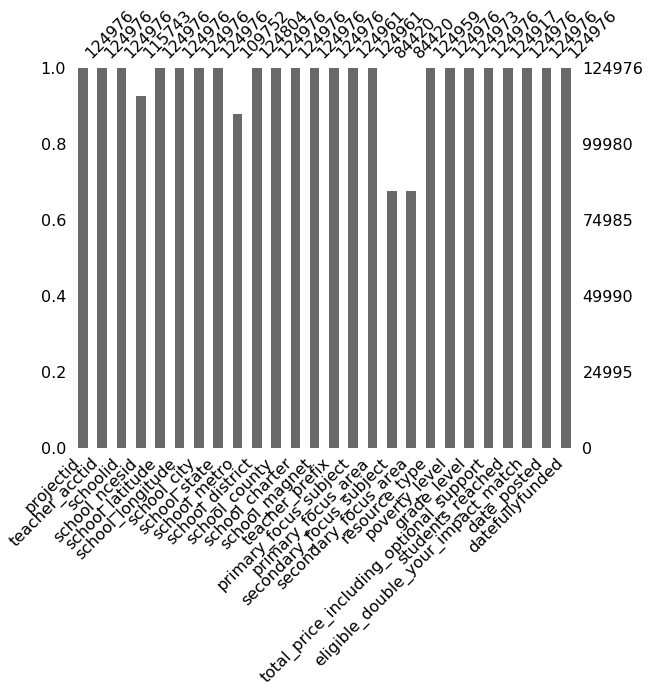

In [13]:
e.missing_bar(df)

In [226]:
# Null Columns
e.null_cols(df)
cat_nulls = ['school_metro',
 'school_district',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'resource_type',
 'grade_level']

In [227]:
## Drop Nulls from categorical variables
for col in cat_nulls:
    df = df[pd.notnull(df[col])]

In [229]:
## Replace null with median value for continuous variables
continuous_nulls = ['students_reached']
pipeline.fill_continuous_null(df, continuous_nulls)

In [230]:
df.shape

(74417, 30)

#### Data Exploration

In [217]:
# Number of teachers with 10+ projects
len(df.groupby('teacher_acctid').filter(lambda x: len(x) > 10).groupby('teacher_acctid').size())

539

In [51]:
discrete_cols = ['school_city','school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type','poverty_level', 'grade_level']

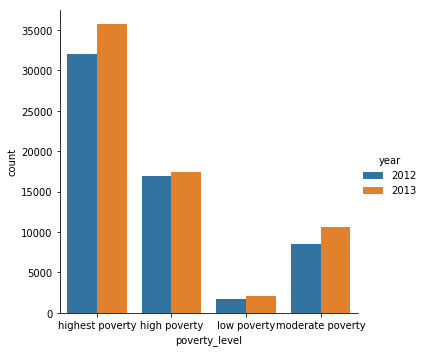

In [56]:
sns.catplot(x='poverty_level', hue='year', kind='count', data=df)

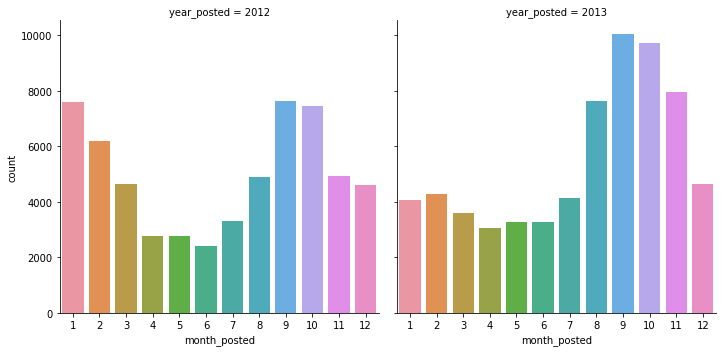

In [68]:
sns.catplot(x='month_posted', col='year_posted', kind='count', data=df)

In [69]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'year_posted', 'month_posted', 'diff', 'outcome'],
      dtype='object')

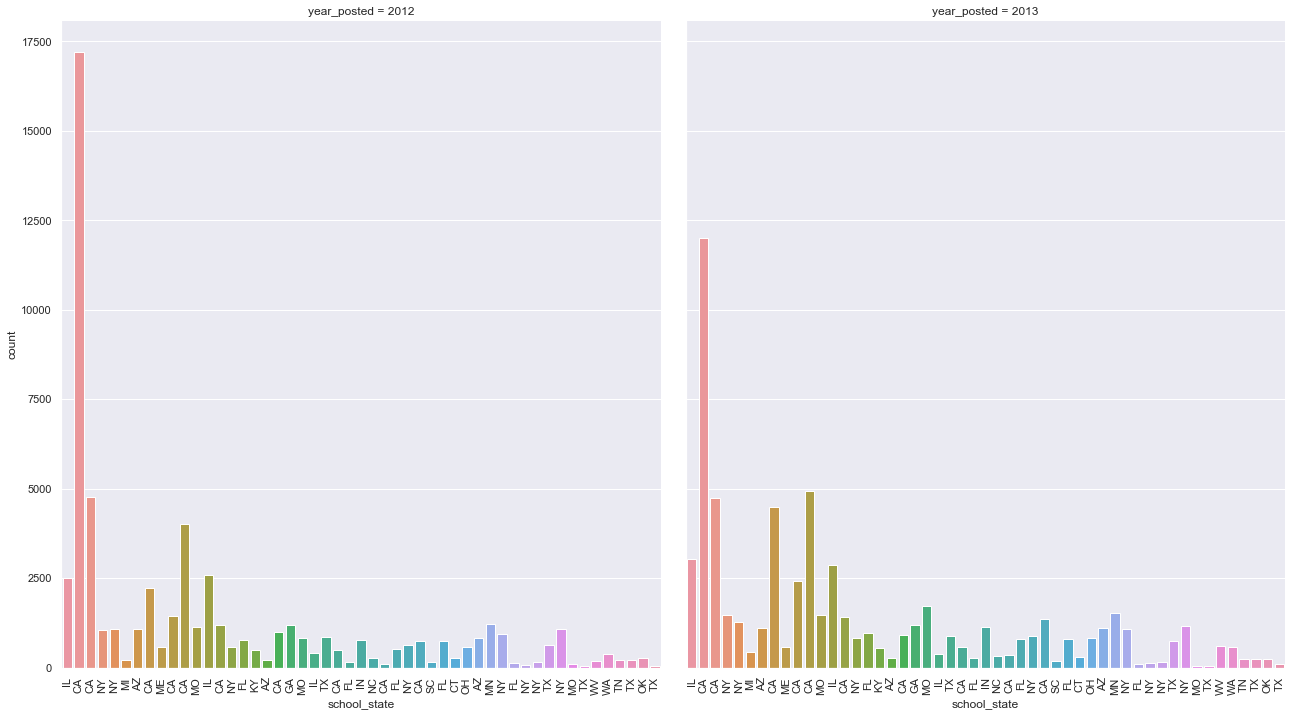

In [78]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.catplot(x='school_state', col='year_posted', kind='count', data=df, height=10, aspect=.9)
ax.set_xticklabels(df['school_state'], rotation=90)

In [94]:
project_counts = df.groupby('year_posted').projectid.nunique()

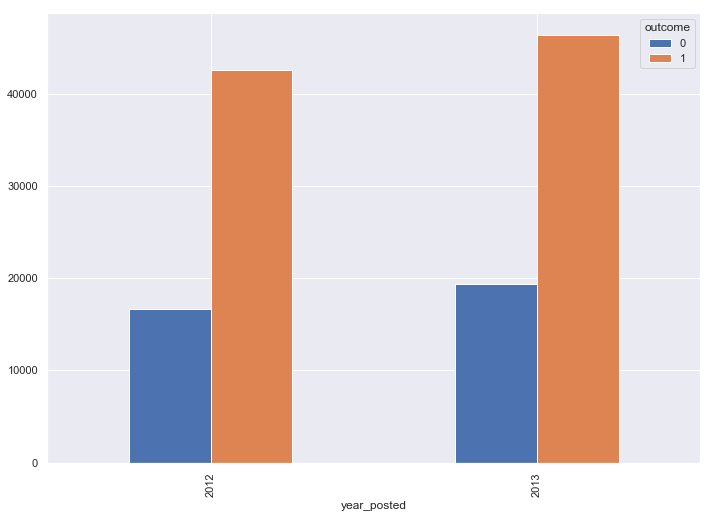

In [114]:
### Total count of projects per year grouped by outcome
ax = df.groupby(['year_posted', 'outcome']).projectid.nunique().unstack().plot(kind='bar')

In [138]:
tst = df.groupby(['month_posted','year_posted','outcome']).size().to_frame('count').reset_index()

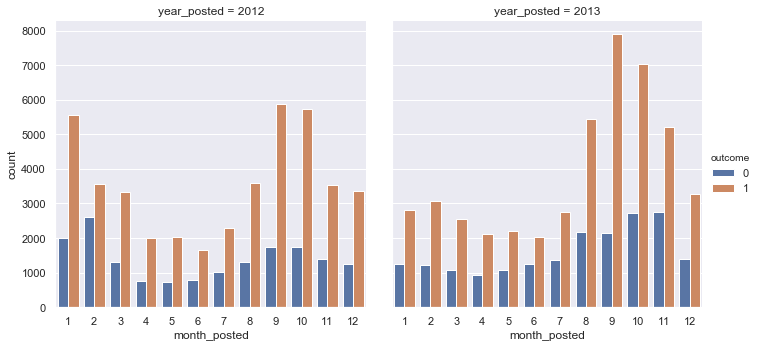

In [143]:
sns.catplot(x='month_posted', col='year_posted', y='count', hue='outcome', kind='bar', data=tst)

In [192]:
tst2 = df.groupby(['month_posted','year_posted','outcome']).size().unstack().reset_index()

In [194]:
tst2['tot'] = tst2.sum(axis=1)

In [196]:
tst2['pct_fulfilled'] = tst2[1] / tst2['tot']

(0, 1)

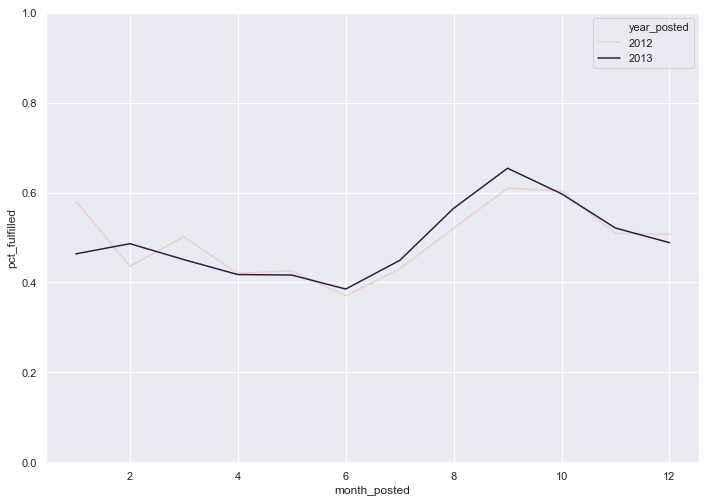

In [200]:
sns.lineplot(x='month_posted', y='pct_fulfilled',hue='year_posted', data=tst2)
plt.ylim(0,1)

(0, 2000)

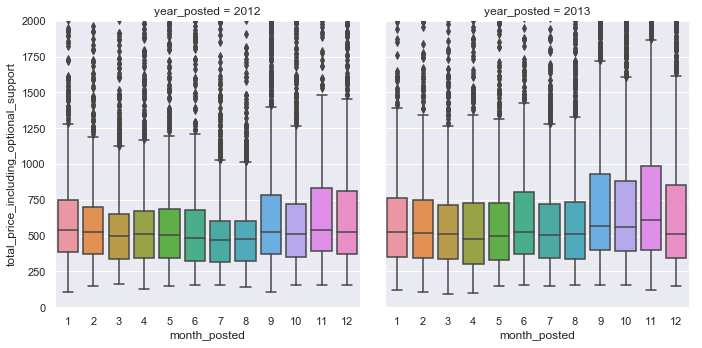

In [244]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(data=df, x="month_posted", y='total_price_including_optional_support', col='year_posted', kind='box')
plt.ylim(0,2000)

(0, 2000)

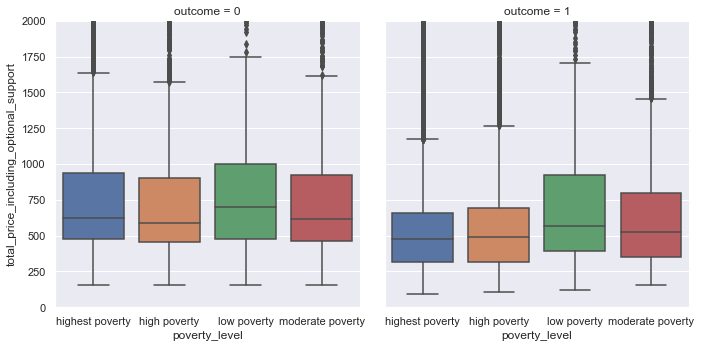

In [251]:
sns.catplot(data=df, x="poverty_level", y='total_price_including_optional_support', col='outcome', kind='box')
plt.ylim(0,2000)

### Generate Features

In [26]:
full_df = p.format_df(df)

#### Modeling

In [243]:
models_to_run = ['RF','DT','GB','KNN','LR','BG']
# models_to_run = ['RF','GB','LR']
clfs, grid = l.define_clfs_params('test')

In [232]:
start_date = full_df['date_posted'].min()

In [46]:
full_df['date_posted'].max()

Timestamp('2013-12-31 00:00:00')

In [52]:
start_date

Timestamp('2012-01-01 00:00:00')

In [233]:
train_start_date = df['date_posted'].min()
end_date = df['date_posted'].max()
window = 6
train_end_date = train_start_date + relativedelta(months=+window) - relativedelta(days=+1)

In [234]:
x_train, y_train, x_test, y_test = pipeline.get_train_test_splits(df, train_start_date, train_end_date, test_start_date, test_end_date)

/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_train['label'] = 'train'


In [235]:
df_percent = df.sample(frac=0.1)

In [257]:
l.clf_loop(models_to_run, clfs, grid, x_train, x_test, y_train, y_test, train_start_date, train_end_date, test_start_date, test_end_date)

RF
DT
GB
KNN
LR
BG


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

,train_start,train_end,test_start,test_end,model_type,clf,parameters,auc-roc,p_at_5,p_at_10,p_at_20
0,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.503346,0.877466,0.938733,0.969367
1,2012-01-01,2012-06-30,2012-07-01,2012-12-31,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.500000,0.998962,0.999481,0.999481
2,2012-01-01,2012-06-30,2012-07-01,2012-12-31,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.500000,0.998962,0.999481,0.999481
3,2012-01-01,2012-06-30,2012-07-01,2012-12-31,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.539615,0.880582,0.603842,0.801921
4,2012-01-01,2012-06-30,2012-07-01,2012-12-31,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.598521,0.860852,0.853583,0.835929
5,2012-01-01,2012-06-30,2012-07-01,2012-12-31,BG,"(LogisticRegression(C=100000.0, class_weight=N...","{'max_samples': 0.5, 'n_estimators': 10}",0.592309,0.839045,0.842160,0.840083


In [263]:
time_periods = l.get_time_periods(df_percent, [6,12])

In [272]:
train_start = time_periods[0][0]
train_end = time_periods[0][1]
test_start = time_periods[0][2]
test_end = time_periods[0][3]

In [270]:
train_start

Timestamp('2012-06-30 00:00:00')

In [280]:
x_train, y_train, x_test, y_test = pipeline.get_train_test_splits(df, train_start, train_end, test_start, test_end)

/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_train['label'] = 'train'


In [278]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [279]:
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [281]:
l.clf_loop(models_to_run, clfs, grid, x_train, x_test, y_train, y_test, train_start_date, train_end_date, test_start_date, test_end_date)

RF
DT
GB
KNN
LR
BG


[[[Timestamp('2012-01-01 00:00:00'),
   Timestamp('2012-12-30 00:00:00'),
   Timestamp('2012-12-31 00:00:00'),
   Timestamp('2013-06-29 00:00:00')],
  Timestamp('2012-06-30 00:00:00'),
  [Timestamp('2012-01-01 00:00:00'),
   Timestamp('2013-06-30 00:00:00'),
   Timestamp('2013-07-01 00:00:00'),
   Timestamp('2013-12-31 00:00:00')],
  [Timestamp('2012-01-01 00:00:00'),
   Timestamp('2012-12-31 00:00:00'),
   Timestamp('2013-01-01 00:00:00'),
   Timestamp('2013-12-31 00:00:00')],
  'RF',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=1, max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  {'max_depth': 1,
   'max_features': 'sqrt',
   'min_samples_split': 10,
 

In [289]:
train_start_date = period[0]
train_start_date = period[1]
test_start_date = period[2]
test_end_date = period[3]

In [290]:
x_train, y_train, x_test, y_test = pipeline.get_train_test_splits(df, train_start_date, train_start_date, test_start_date, test_end_date)

/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_train['label'] = 'train'


In [300]:
rv_row = l.clf_loop(models_to_run, clfs, grid, x_train, x_test, y_train, y_test, train_start_date, train_end_date, test_start_date, test_end_date)

RF
DT
GB
KNN
LR
BG


In [302]:
rv_lst = []

In [303]:
rv_lst.extend(rv_row)

In [305]:
rv_df = pd.DataFrame(rv_lst, columns=('train_start','train_end','test_start','test_end','model_type','clf', 'parameters','baseline', 'auc-roc',
                                            'p_at_1', 'p_at_2', 'p_at_5', 'p_at_10', 'p_at_20', 'p_at_30', 'p_at_50'))

,train_start,train_end,test_start,test_end,model_type,clf,parameters,baseline,auc-roc,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50
0,2012-06-30,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",outcome 0.7446 dtype: float64,0.516403,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2012-06-30,2012-06-30,2012-07-01,2012-12-31,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",outcome 0.7446 dtype: float64,0.502860,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2012-06-30,2012-06-30,2012-07-01,2012-12-31,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",outcome 0.7446 dtype: float64,0.475987,1.000000,1.000000,0.766355,0.883178,0.531412,0.567670,0.740498
3,2012-06-30,2012-06-30,2012-07-01,2012-12-31,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",outcome 0.7446 dtype: float64,0.537592,1.000000,1.000000,0.695742,0.779855,0.864226,0.662167,0.797300
4,2012-06-30,2012-06-30,2012-07-01,2012-12-31,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",outcome 0.7446 dtype: float64,0.500000,0.994792,0.997403,0.998962,0.999481,0.999481,0.999654,0.999792
5,2012-06-30,2012-06-30,2012-07-01,2012-12-31,BG,"(LogisticRegression(C=100000.0, class_weight=N...","{'max_samples': 0.5, 'n_estimators': 10}",outcome 0.7446 dtype: float64,0.510304,0.822917,0.810390,0.782970,0.765317,0.758567,0.756317,0.748183


In [313]:
results = l.run_time_loop(df, models_to_run, clfs, grid, [6,12])

/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Input:


RF
DT
GB
KNN
LR
BG


/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Input:


RF
DT
GB
KNN
LR
BG


/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Input:


RF
DT
GB
KNN
LR
BG


/Users/jamesjensen/Documents/harris/q3_18_19/ml/ml-pub-policy/hw3/pipeline.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Input:


RF
DT
GB
KNN
LR
BG


In [314]:
results

,train_start,train_end,test_start,test_end,model_type,clf,parameters,baseline,auc-roc,p_at_1,...,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50
0,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",outcome 0.7446 dtype: float64,0.500996,1.000000,...,1.000000,1.000000,1.000000,0.013388,0.026846,0.067150,0.134300,0.268601,0.402901,0.671501
1,2012-01-01,2012-06-30,2012-07-01,2012-12-31,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",outcome 0.7446 dtype: float64,0.553844,1.000000,...,0.679647,0.786431,0.871755,0.013388,0.026846,0.067150,0.111289,0.182554,0.316854,0.585385
2,2012-01-01,2012-06-30,2012-07-01,2012-12-31,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",outcome 0.7446 dtype: float64,0.553844,1.000000,...,0.679647,0.786431,0.871755,0.013388,0.026846,0.067150,0.111289,0.182554,0.316854,0.585385
3,2012-01-01,2012-06-30,2012-07-01,2012-12-31,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",outcome 0.7446 dtype: float64,0.531842,1.000000,...,0.800363,0.713223,0.775701,0.013388,0.026846,0.060944,0.080678,0.214978,0.287358,0.520884
4,2012-01-01,2012-06-30,2012-07-01,2012-12-31,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",outcome 0.7446 dtype: float64,0.500000,0.994792,...,0.999481,0.999654,0.999792,0.013318,0.026776,0.067080,0.134231,0.268461,0.402761,0.671362
5,2012-01-01,2012-06-30,2012-07-01,2012-12-31,BG,"(LogisticRegression(C=100000.0, class_weight=N...","{'max_samples': 0.5, 'n_estimators': 10}",outcome 0.7446 dtype: float64,0.542866,0.817708,...,0.786864,0.780201,0.767809,0.010948,0.021895,0.054180,0.107803,0.211352,0.314343,0.515585
6,2012-01-01,2012-12-30,2012-12-31,2013-06-29,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",outcome 0.688808 dtype: float64,0.490535,0.627907,...,0.656659,0.771106,0.862531,0.009051,0.013298,0.048274,0.051067,0.190636,0.335792,0.626103
7,2012-01-01,2012-12-30,2012-12-31,2013-06-29,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",outcome 0.688808 dtype: float64,0.546351,1.000000,...,0.759430,0.839620,0.903633,0.014415,0.028942,0.072522,0.088725,0.220472,0.365627,0.655939
8,2012-01-01,2012-12-30,2012-12-31,2013-06-29,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",outcome 0.688808 dtype: float64,0.523081,0.992248,...,0.625481,0.633821,0.780172,0.014303,0.028830,0.072410,0.145044,0.181585,0.276008,0.566320
9,2012-01-01,2012-12-30,2012-12-31,2013-06-29,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",outcome 0.688808 dtype: float64,0.524864,0.906977,...,0.733256,0.588145,0.752925,0.013074,0.022572,0.045368,0.086937,0.212873,0.256118,0.546542
